In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from scipy import io

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [2]:
def matlab2datetime(matlab_datenum):
    day = datetime.fromordinal(int(matlab_datenum))
    dayfrac = timedelta(days=matlab_datenum%1) - timedelta(days = 366)
    return day + dayfrac

In [3]:
# locations
fobs = '../offline_data/buoy_bulkwave_met_obs_qc.mat'
fpred = '../offline_data/cfsr_buoy_met_pred.mat'

In [4]:
obs = io.loadmat(fobs)
pred = io.loadmat(fpred)
print(pred.keys())

dict_keys(['__header__', '__version__', '__globals__', 'wndspd', 'wnddir', 'time', 'lat', 'lon', 'id'])


In [5]:
# Estimate u,v for pred
pred['u'] = pred['wndspd']*np.cos((90-pred['wnddir']+180)*np.pi/180.0)
pred['v'] = pred['wndspd']*np.sin((90-pred['wnddir']+180)*np.pi/180.0)

In [6]:
# Select just one location for now
loc = 1
print(obs['id'][loc])

[array(['46041'], dtype='<U5')]


In [7]:
# Interp onto prediction time series
ou = np.interp(np.squeeze(pred['time']),np.squeeze(obs['time']),np.squeeze(obs['u'][loc,:]))
pu = pred['u'][:,loc]
ov = np.interp(np.squeeze(pred['time']),np.squeeze(obs['time']),np.squeeze(obs['v'][loc,:]))
pv = pred['v'][:,loc]
t = [matlab2datetime(tt[0]) for tt in pred['time']]
print([ou.shape,pu.shape])

[(272124,), (272124,)]


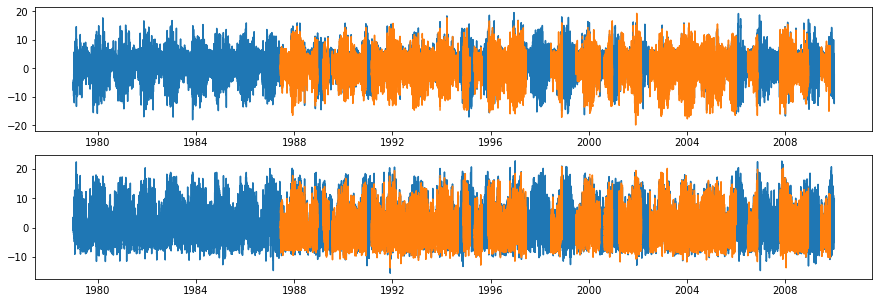

In [8]:
# Plot of data availabitlity
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,5))
ax1.plot(t,pu)
ax1.plot(t,ou)

ax2.plot(t,pv)
ax2.plot(t,ov)

In [9]:
# Generate prior wind speeds, up to X hours back in time using np.roll() like circshift
hr_back = 6
hr_forward = 1
trim = np.max([hr_back,hr_forward])

HU = pd.DataFrame()
HV = pd.DataFrame()

for ii in range(hr_back):
    col = str(ii)
    HU[col] = np.roll(ou,ii)
    HV[col] = np.roll(ov,ii)

# Create future time step to predict
fu = np.roll(ou,hr_forward)
fv = np.roll(ov,hr_forward)
    
# Trim ends
HU = HU[trim:-trim]
HV = HV[trim:-trim]
fu = fv[trim:-trim]
fv = fv[trim:-trim]

# Nan out times with any NaNs
msk1 = HU.isnull()
msk1 = msk1.any(axis=1)
msk2 = np.isnan(fu)
msk = msk1 | msk2
HU[msk] = np.nan
HV[msk] = np.nan
fu[msk] = np.nan
fv[msk] = np.nan

# Remove NaN values
fu = fu[~np.isnan(fu)]
fv = fv[~np.isnan(fv)]
HU = HU.dropna()
HV = HV.dropna()

print(HU.shape)
print(fu.shape)

(142031, 6)
(142031,)


In [10]:
# train test sets
x_tr, x_te, y_tr, y_te = train_test_split(HU, fu, test_size = 0.25, random_state = 42)

In [11]:
# creating an object of LinearRegression class
LR = LinearRegression()
# fitting the training data
LR.fit(x_tr,y_tr)
# Make predictions
y_p = np.squeeze(LR.predict(x_te))
y = np.squeeze(y_te)

r2 = r2_score(y.T,y_p)
mae = np.mean(np.abs(y.T-y_p))
print([r2,mae])

[0.3042318310396698, 2.844577199462721]


In [16]:
# Numerical Model prediction error 
mae = np.nanmean(np.abs(ou-pu))
print(mae)

1.7194398300215474


In [12]:
LR.coef_

array([ 0.03513493, -0.14618574, -0.1636249 , -0.09996996, -0.05527509,
       -0.20003767])

In [18]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state= 40)

rf.fit(x_tr,y_tr)

RandomForestRegressor(random_state=40)

In [19]:
y_p = rf.predict(x_te)
mae = np.mean(np.abs(y_p-y_te))
print(mae)

2.5406507234288185
